In [150]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

A = np.array([[0.9512, 0],
              [0.0476, 0.9512]], ndmin = 2)
B = np.array([[1], [2]], ndmin = 2)
C = np.array([0, 1], ndmin = 2)

mean_w = np.array([0, 0])
Q = 1e-3 * np.array([[9.506, 0.234],
                              [0.234, 9.512]], ndmin = 2)
mean_v = 0
R = 0.0125

h = 0.1 # sampling period in second

mu_0 = np.array([5, 5])
P_0 = np.array([[1, 0],
                        [0, 1]], ndmin = 2)

u = np.loadtxt("./Data_linear_case/input_linear_case.txt", skiprows = 1, usecols = 0)
y = np.loadtxt("./Data_linear_case/Measured_output_linear_case.txt", skiprows = 1, usecols = 0)
true_x1 = np.loadtxt("./Data_linear_case/True_state_x1_linear_case.txt", skiprows = 1, usecols = 0)
true_x2 = np.loadtxt("./Data_linear_case/True_state_x2_linear_case.txt", skiprows = 1, usecols = 0)

assert len(u) == len(y) == len(true_x1) == len(true_x2)

number_step_max = len(u)

In [151]:
def forecast_step(A, ens_x_k_1, B, u_k, mean_w, Q):
    ensemble_size = len(ens_x_k_1)
    wk = np.random.multivariate_normal(mean_w, Q, size = ensemble_size)
    wk = np.reshape(wk, (ensemble_size, 2, 1))
    ens_x_tilde_k = A@ens_x_k_1 + B*u_k + wk
    return ens_x_tilde_k

def make_observations_step(C, ens_x_tilde_k, mean_v, R):
    ensemble_size = len(ens_x_tilde_k)
    vk = np.random.normal(mean_v, R, size = ensemble_size)
    vk = np.reshape(vk, (ensemble_size, 1, 1))
    ens_y_tilde_k = C@ens_x_tilde_k - vk
    return ens_y_tilde_k

def update_step(C, ens_x_tilde_k, R, yk, ens_y_tilde_k):
    P_tilde_hat_k = np.cov(np.squeeze(ens_x_tilde_k), rowvar = False)
    K_tilde_k = P_tilde_hat_k@C.T@np.linalg.inv(C@P_tilde_hat_k@C.T + R)
    ens_x_hat_k = ens_x_tilde_k + K_tilde_k@(yk - ens_y_tilde_k)
    return ens_x_hat_k

In [163]:
mu = pd.DataFrame(columns = ["mu_x1", "mu_x2"])

ensemble_size = 999
ens_x_hat_k_1 = np.random.multivariate_normal(mu_0, P_0, size = ensemble_size)
ens_x_hat_k_1 = np.reshape(ens_x_hat_k_1, (ensemble_size, 2, 1))

for i in range(number_step_max):
    ens_x_tilde_k = forecast_step(A, ens_x_hat_k_1, B, u[i], mean_w, Q)
    ens_y_tilde_k = make_observations_step(C, ens_x_tilde_k, mean_v, R)
    ens_x_hat_k_1 = update_step(C, ens_x_tilde_k, R, y[i], ens_y_tilde_k)
    mu.loc[i] = np.mean(ens_x_hat_k_1, axis = 0).flatten().tolist()


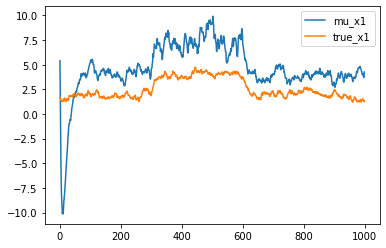

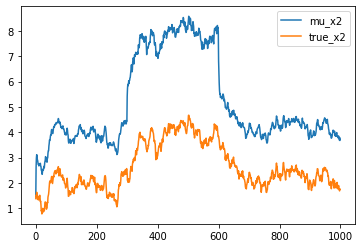

In [164]:
plt.figure()
plt.plot(mu["mu_x1"])
plt.plot(true_x1)
plt.legend(["mu_x1", "true_x1"])
plt.show()

plt.figure()
plt.plot(mu["mu_x2"])
plt.plot(true_x2)
plt.legend(["mu_x2", "true_x2"])
plt.show()